In [45]:
import ROOT as rt
# import root_numpy as rtnp
import csv
import os
from collections import OrderedDict
import uproot
import pandas as pd
import sys
import scipy
import awkward
import numpy as np
import time
import numba
from numba import jit
from matplotlib import pyplot as plt
sys.path.append('/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/lib/')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot
import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 0
wH = 1
Z_MASS = 91.2
# donotdelete = []
print(sys.version)

3.6.8 (default, Aug  7 2019, 17:28:10) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-39)]


In [46]:
%%time
fpath =OrderedDict()
tree = OrderedDict()
path = '/storage//cms/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/MC_Fall18/v2/v93/normalized/'
fpath['ee, m_{s} = 0.1 GeV, c#tau = 100 mm'] =path + 'ggH_HToSS_SToEE_ms0p1_pl100_137000pb_weighted.root'
fpath['ee, m_{s} = 0.4 GeV, c#tau = 500 mm'] = path + 'ggH_HToSS_SToEE_ms0p1_pl500_137000pb_weighted.root'
fpath['ee, m_{s} = 4 GeV, c#tau = 500 mm'] = path + 'ggH_HToSS_SToEE_ms0p4_pl500_137000pb_weighted.root'
fpath['#pi^{0}#pi^{0}, m_{s} = 1 GeV, c#tau = 100 mm'] = path + 'ggH_HToSS_SToPi0Pi0_ms1_pl100_137000pb_weighted.root'
fpath['#pi^{0}#pi^{0}, m_{s} = 1 GeV, c#tau= 500 mm'] = path + 'ggH_HToSS_SToPi0Pi0_ms1_pl500_137000pb_weighted.root'
fpath['k^{+}k^{-}, m_{s} = 1.5 GeV, c#tau = 500 mm'] = path + 'ggH_HToSS_SToKPlusKMinus_ms1p5_pl500_137000pb_weighted.root'
fpath['#pi^{+}#pi^{-}, m_{s} = 1 GeV, c#tau = 500 mm'] = path + 'ggH_HToSS_SToPiPlusPiMinus_ms1_pl500_137000pb_weighted.root'

for k,v in fpath.items():
    root_dir = uproot.open(v) 
    tree[k] = root_dir['MuonSystem']

CPU times: user 1.98 s, sys: 51 ms, total: 2.03 s
Wall time: 2.03 s


a
0.881 Ceff ee, m_{s} = 0.1 GeV, c#tau = 100 mm
a
0.883 Ceff ee, m_{s} = 0.4 GeV, c#tau = 500 mm
a
0.888 Ceff ee, m_{s} = 4 GeV, c#tau = 500 mm
a
0.882 Ceff #pi^{0}#pi^{0}, m_{s} = 1 GeV, c#tau = 100 mm
a
0.886 Ceff #pi^{0}#pi^{0}, m_{s} = 1 GeV, c#tau= 500 mm
a
0.928 Ceff k^{+}k^{-}, m_{s} = 1.5 GeV, c#tau = 500 mm
a
0.93 Ceff #pi^{+}#pi^{-}, m_{s} = 1 GeV, c#tau = 500 mm


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: #pi^{+}#pi^{-}, m_{s} = 1 GeV, c#tau = 500 mm (Potential memory leak).


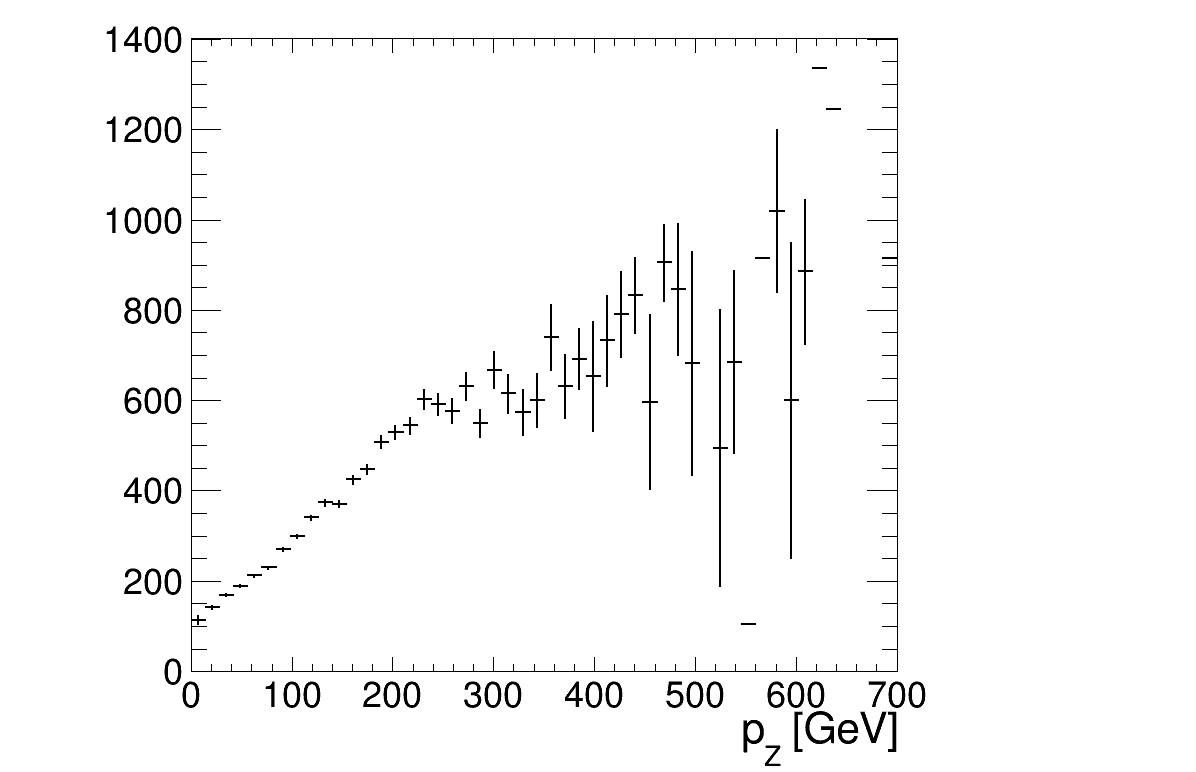

In [47]:
JET_PT_CUT = 10.0
MUON_PT_CUT = 20.0
jetPt_cut = 50
cluster_index = '3'
gLLP_decay_vertex_r={}
cscRechitCluster3_match_gLLP_decay_r={}
gLLP_decay_vertex_z={}
cscRechitCluster3_match_gLLP_decay_z={}
weight = {}
pileupWeight = {}
evtNum = {}
runNum = {}
lumiSec = {}
sel_ev = {}
gLLP_beta = {}
gLLP_csc = {}
gLLP_ctau = {}
gLLP_eta={}
cscRechitClusterX = {}
cscRechitClusterY = {}
cscRechitClusterZ = {}
cscRechitClusterPhi = {}
cscRechitClusterEta = {}
cscRechitCluster3NStation = {}
cscRechitClusterNChamber = {}
cscRechitClusterSize = {}
cscRechitClusterAvgStation = {}
cscRechitCluster3XSpread={}
cscRechitCluster3YSpread={}
cscRechitCluster3ZSpread={}
cscRechitClusterSize={}
cscRechitCluster3Eta={}
cscRechitCluster3AvgStation5={}
weight_ctau={}
NEWweight_ctau={}
t1NEW={}
t2NEW={}
weight_ctauNew={}
sel_ev2={}
gLLP_eta2={}
cluster_match_eta={}
weight_ctau_1002500={}
gLLP_e={}
cluster_match_energy={}
cscRechitCluster3_match_gLLP_pt={}
cscRechitCluster3Z={}
cscRechitClusterSize3={}
newL=[]
for k, T in tree.items():
    print('a')
########### SELECTION: CLUSTERS ############

    sel_rechitcluster = T.array('cscRechitCluster' + cluster_index + '_match_gLLP_csc')==1   
    sum_sel_rechitcluster = sel_rechitcluster.any()
  #  sum_sel_rechitcluster = T.array('cscRechitCluster' + cluster_index + '_match_gLLP_csc').any()

########### SELECTION: JETS ############
   
    sel_jet = np.logical_and(T.array('jetPt') > jetPt_cut, np.abs(T.array('jetEta')) < 2.4 )

########### SELECTION: EVENTS ############
    sel_ev[k] = (np.sum(T.array('gLLP_csc'),axis = 1) > 0)
    sel_ev[k]  = np.logical_and(sel_ev[k],sel_rechitcluster.sum() == 1)
    UWAccep = (np.count_nonzero(sel_ev[k])) / len(sel_ev[k]) #acceptance for UW
    clusterMatched = (np.count_nonzero(sum_sel_rechitcluster)) / len(sum_sel_rechitcluster) #events w/ a cluster matched to LLP
    ClusteringEff = UWAccep/clusterMatched  
    t1= T.array('gLLP_ctau')[:,0][sel_ev[k]][np.logical_and((np.logical_not(np.isnan((T.array('gLLP_ctau')[:,0][sel_ev[k]])))),
                           (np.logical_not(np.isnan((T.array('gLLP_ctau')[:,1][sel_ev[k]])))))] #for rw grpah only 
    t2= (T.array('gLLP_ctau')[:,1])[sel_ev[k]][np.logical_and((np.logical_not(np.isnan((T.array('gLLP_ctau')[:,0][sel_ev[k]])))),
                                 (np.logical_not(np.isnan((T.array('gLLP_ctau')[:,1][sel_ev[k]])))))] #for rw

    tau_old= 100
    tau_new=50
    expIn= (t1+t2)* ((1/tau_old)-(1/tau_new))
    weight1= (tau_old/tau_new)**2
    weight2=np.exp(expIn)
    weight_ctau[k]=weight1*weight2 
    gLLP_beta[k] = T.array('gLLP_beta')[sel_ev[k]]
    gLLP_csc[k] = T.array('gLLP_csc')[sel_ev[k]] #this one!!
    gLLP_eta[k]= T.array('gLLP_eta')[T.array('gLLP_csc')==1]  
    gLLP_e[k]= T.array('gLLP_e')[T.array('gLLP_csc')==1] 
    gLLP_decay_vertex_r[k]=T.array('gLLP_decay_vertex_r')[T.array('gLLP_csc')==1] 
    gLLP_decay_vertex_z[k]= T.array('gLLP_decay_vertex_z')[T.array('gLLP_csc')==1] 
    weight[k] = T.array('weight')[sel_ev[k]]
    evtNum[k] =  T.array('evtNum')[sel_ev[k]] 
    runNum[k] =  T.array('runNum')[sel_ev[k]]
    lumiSec[k] =  T.array('lumiSec')[sel_ev[k]]
    print(round((np.count_nonzero(np.concatenate(sel_rechitcluster))/ len(np.concatenate(sel_rechitcluster))), 3), 'Ceff',k)
    cscRechitClusterSize[k] =  T.array('cscRechitCluster' + cluster_index + 'Size')[sel_rechitcluster][sel_ev[k]].flatten()
    
#     ##### cluster-level variables ####  

    cscRechitClusterPhi[k] = T.array('cscRechitCluster' + cluster_index + 'Phi')[sel_rechitcluster][sel_ev[k]].flatten()
    cscRechitCluster3NStation[k] = T.array('cscRechitCluster' + cluster_index + 'NStation')[sel_rechitcluster][sel_ev[k]].flatten()
    cscRechitClusterX[k] = T.array('cscRechitCluster' + cluster_index + 'X')[sel_rechitcluster][sel_ev[k]].flatten()
    cscRechitCluster3XSpread[k]=T.array('cscRechitCluster' + cluster_index + 'XSpread')[sel_rechitcluster][sel_ev[k]].flatten()
    cscRechitCluster3YSpread[k]=T.array('cscRechitCluster' + cluster_index + 'YSpread')[sel_rechitcluster][sel_ev[k]].flatten()
    cscRechitClusterY[k] = T.array('cscRechitCluster' + cluster_index + 'Y')[sel_rechitcluster][sel_ev[k]].flatten()
    cscRechitClusterEta[k] = T.array('cscRechitCluster' + cluster_index + 'Eta')[sel_rechitcluster][sel_ev[k]].flatten()
    cscRechitClusterPhi[k] = T.array('cscRechitCluster' + cluster_index + 'Phi')[sel_rechitcluster][sel_ev[k]].flatten()
    cscRechitClusterAvgStation[k] = T.array('cscRechitCluster' + cluster_index + 'AvgStation5')[sel_rechitcluster][sel_ev[k]].flatten()
    cscRechitCluster3Z[k]= T.array('cscRechitCluster' + cluster_index + 'Z')[sel_rechitcluster]
    cscRechitCluster3_match_gLLP_decay_z[k]=((T.array('cscRechitCluster' + cluster_index + '_match_gLLP_decay_z'))[sel_rechitcluster])
    cscRechitClusterEta[k]= np.abs(cscRechitClusterEta[k])
    cscRechitClusterAvgStation[k]=np.abs(cscRechitClusterAvgStation[k])
    cluster_match_eta[k]= T.array('cscRechitCluster' + cluster_index + '_match_gLLP_eta')[sel_rechitcluster][sel_ev[k]].flatten()
    cscRechitCluster3_match_gLLP_pt[k] = (T.array('cscRechitCluster' + cluster_index + '_match_gLLP_pt'))[sel_rechitcluster][sel_ev[k]].flatten()
    cscRechitClusterSize3[k] =  T.array('cscRechitCluster' + cluster_index + 'Size')[sel_rechitcluster]
    def Bigger(lst1, lst2):
        newL=[]
        for i in range(0, len(lst1)):
            if lst1[i]>lst2[i]:
                newL.append(lst1[i]/lst2[i])
        return newL

    cluster_match_energy[k]= ((T.array('cscRechitCluster' + cluster_index + '_match_gLLP_e'))[sel_rechitcluster])
    
    def CutAtEnergy(lst, newNum):
        v=0
        for x in lst[k]:
            print(lst[k][v], 'v')
            for y in lst[k][v]:
                if lst[k][v] <= newNum:
                    newL[k].append(lst[k][v])
                v+=1
        print(newL, 'newL')

    cscRechitCluster3_match_gLLP_decay_r[k]=((T.array('cscRechitCluster' + cluster_index + '_match_gLLP_decay_r'))[sel_rechitcluster])
    cscRechitClusterZ[k] = T.array('cscRechitCluster' + cluster_index + 'Z')[sel_rechitcluster]
    cscRechitCluster3ZSpread[k]=T.array('cscRechitCluster' + cluster_index + 'ZSpread')[sel_rechitcluster][sel_ev[k]].flatten()
    def CutAtWeight(lst, num, weight):
        sum=0
        for i in range(0, len(lst)-1):
            if lst[i]>num:
                sum+=weight[i]
        return sum
    def CutAtWeightUW(lst,num):
        sum=0
        for i in range(0, len(lst)-1):
            if lst[i]>num:
                sum+=1
        return sum

start_t = time.time()
c = rt.TCanvas('c','c', 1200, 800)
h = {}
momentumZ={}
leg = rt.TLegend(0.36,.79,0.5,0.94)  # 1= left/right, 2= height/space out of legend vertical 3 = space of legend horiz, # 4 = vertical height 
leg.SetTextSize(0.022)
leg.SetBorderSize(0)
leg.SetTextFont(42)
keys= ('ee, m_{s} = 0.1 GeV, c#tau = 100 mm', 'ee, m_{s} = 0.4 GeV, c#tau = 500 mm', 'ee, m_{s} = 4 GeV, c#tau = 500 mm', '#pi^{0}#pi^{0}, m_{s} = 0.1 GeV, c#tau = 100 mm',
     '#pi^{0}#pi^{0}, m_{s} = 0.1 GeV, c#tau= 500 mm', 'k^{+}k^{-}, m_{s} = 1.5 GeV, c#tau = 500 mm', '#pi^{+}#pi^{-}, m_{s} = 1 GeV, c#tau = 500 mm') 

momentumZ[k]= (cscRechitCluster3_match_gLLP_pt[k].flatten())*np.sinh(cluster_match_eta[k].flatten())
h[k] = create_TH2D((np.column_stack((momentumZ[k],cscRechitClusterSize[k]))), axis_title=['p_{Z} [GeV]','Rechit Cluster Size', 'Number of Events'], name=k, binning=[50,0,700,50,0,1500])
h[k] = h[k].ProfileX()
h[k].Draw()

c.SetLogz()
c.SetRightMargin(.25)
rt.gPad.Update()
#c.SetLeftMargin(.8)
c.Draw()


1
2
3
4
5
6
7


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: ee, m_{s} = 0.1 GeV, c#tau = 100 mm (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: ee, m_{s} = 0.4 GeV, c#tau = 500 mm (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: ee, m_{s} = 4 GeV, c#tau = 500 mm (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: #pi^{0}#pi^{0}, m_{s} = 1 GeV, c#tau = 100 mm (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: #pi^{0}#pi^{0}, m_{s} = 1 GeV, c#tau= 500 mm (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: k^{+}k^{-}, m_{s} = 1.5 GeV, c#tau = 500 mm (Potential memory leak).
Info in <TCanvas::Print>: ps file c.ps has been created


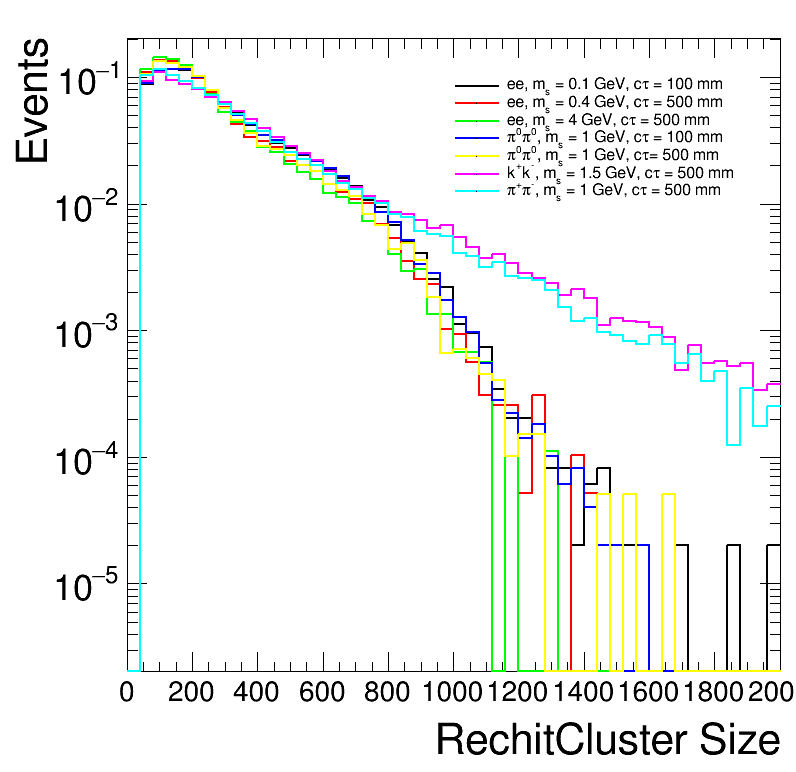

In [48]:
### Rechit Cluster Size vs. Events for all samples ###
c = rt.TCanvas('c','c', 800, 800)
h = {}
leg = rt.TLegend(0.87, 0.74, 0.56, 0.9) 
leg.SetTextSize(0.022)
leg.SetBorderSize(0)
leg.SetTextFont(42)

UWkeyLst = ['ee, m_{s} = 0.1 GeV, c#tau = 100 mm','ee, m_{s} = 0.4 GeV, c#tau = 500 mm','ee, m_{s} = 4 GeV, c#tau = 500 mm', '#pi^{0}#pi^{0}, m_{s} = 1 GeV, c#tau = 100 mm',
          '#pi^{0}#pi^{0}, m_{s} = 1 GeV, c#tau= 500 mm', 'k^{+}k^{-}, m_{s} = 1.5 GeV, c#tau = 500 mm', '#pi^{+}#pi^{-}, m_{s} = 1 GeV, c#tau = 500 mm']
colorLst = [2, 0, 3, 1, 7]
count = 1
for a in UWkeyLst:
    print(count)
    h[a] = create_TH1D(cscRechitClusterSize[a], axis_title = ['RechitCluster Size', 'Events'], name = a, binning = [50, 0, 2000])
    #h[a].SetLineColor(std_color_list[colorLst[count]])
    h[a].SetLineColor(count)
    h[a].GetYaxis().SetRangeUser(0.1, 10000)
    leg.AddEntry(h[a], a)
    h[a].GetXaxis().SetLabelSize(0.04)
    h[a].DrawNormalized('same hist') 
    count += 1
leg.Draw()
c.SetLogy()
c.Draw()
c.SaveAs()

0.3106318694981847 Ceff
0.29741495781667515 Ceff
0.31081148130690417 Ceff
0.6422235892847156 Ceff
0.6143280244189913 Ceff


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: ee, m_{s} = 0.1 GeV, c#tau = 100 mm (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: #pi^{0}#pi^{0}, m_{s} = 1 GeV, c#tau= 500 mm (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: #pi^{0}#pi^{0}, m_{s} = 1 GeV, c#tau = 100 mm (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: k^{+}k^{-}, m_{s} = 1.5 GeV, c#tau = 500 mm (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: #pi^{+}#pi^{-}, m_{s} = 1 GeV, c#tau = 500 mm (Potential memory leak).
Info in <TCanvas::Print>: ps file c.ps has been created


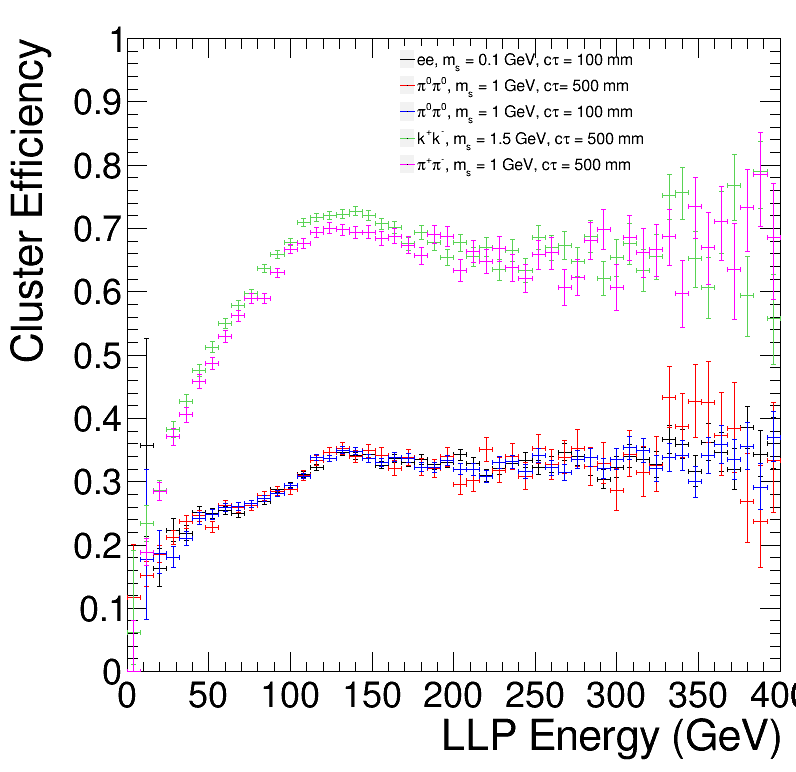

In [49]:
####CEff Vs. Energy####
start_t = time.time()
c = rt.TCanvas('c','c', 800, 800)
h = {}
j = {}
pEff1 = {}
leg = rt.TLegend(0.5, 0.77, 0.6, 0.94)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)
leg.SetTextFont(42)
keys = ['ee, m_{s} = 0.1 GeV, c#tau = 100 mm','#pi^{0}#pi^{0}, m_{s} = 1 GeV, c#tau= 500 mm',  '#pi^{0}#pi^{0}, m_{s} = 1 GeV, c#tau = 100 mm',
        'k^{+}k^{-}, m_{s} = 1.5 GeV, c#tau = 500 mm', '#pi^{+}#pi^{-}, m_{s} = 1 GeV, c#tau = 500 mm']

i = 0
for k in keys: 
    cluster_match_energy[k] = np.abs(cluster_match_energy[k])
    gLLP_e[k] = np.abs(gLLP_e[k])   
    h[k] = create_TH1D(cluster_match_energy[k].flatten(), axis_title = ['LLP Energy (GeV)', 'Cluster Efficiency'], name = k, binning = [50, 0, 400])
    j[k] = create_TH1D(gLLP_e[k].flatten(), axis_title = ['LLP Energy (GeV)', 'Cluster Efficiency'], name = k, binning = [50, 0, 400])
    pEff1[k] = rt.TEfficiency(h[k], j[k])
    
    print(h[k].Integral()/j[k].Integral(), 'Ceff')
    leg.AddEntry(pEff1[k], keys[i])
    pEff1[k].SetLineColor(std_color_list[i])
    pEff1[k].Draw('AP' if i == 0 else 'P same')
    rt.gPad.Update()
    pEff1[k].GetPaintedGraph().GetHistogram().GetXaxis().SetLimits(0, 400)
    pEff1[k].GetPaintedGraph().SetMaximum(1)
    pEff1[k].GetPaintedGraph().SetMinimum(0)
    i += 1
   
##to add geometry of the detector##
#     ymax = pEff1[k].GetPaintedGraph().GetHistogram().GetMaximum()
#     ymin = pEff1[k].GetPaintedGraph().GetHistogram().GetMinimum()
#     xmin = pEff1[k].GetPaintedGraph().GetHistogram().GetXaxis().GetXmin()
#     xmax = pEff1[k].GetPaintedGraph().GetHistogram().GetXaxis().GetXmax()
#     if r:
#         l = rt.TLine(350,ymin, 350, ymax)
#         l.SetLineWidth(2)
#         l.SetLineStyle(2)
#         l.Draw()
#         text = rt.TLatex()
#         text.SetTextSize(0.04)
#         text.DrawLatex(150, ymax*0.94, “Inner ring”)
#         text.DrawLatex(400, ymax*0.94, “Outer ring”)
#else:
#     boxes = []
#     boxes.append(rt.TBox(xmin, ymin, 568, ymax)) #in front of ME11
#     boxes.append(rt.TBox(632, ymin, 671, ymax)) #between ME11 and ME12
#     boxes.append(rt.TBox(724, ymin, 789, ymax)) #between ME12 and station2
#     boxes.append(rt.TBox(849, ymin, 911, ymax)) #between station2 and station3
#     boxes.append(rt.TBox(970, ymin, 1002, ymax)) #between station3 and station4
#     boxes.append(rt.TBox(1073, ymin, xmax, ymax)) #beyond CMS
#     for b in boxes:
#         b.SetFillColor(15)
#         b.SetFillStyle(3001)
#         b.Draw('same')
#     l = rt.TLatex()
#     l.SetTextSize(0.08)
#     l.SetTextColor(12)
#     l.SetTextAngle(90)
#     l.DrawLatex(550, ymax*0.7, 'Steel')
#     l2 = rt.TLatex()
#     l2.SetTextSize(0.06)
#     l2.SetTextColor(13)
#     l2.SetTextAngle(90)
#     l2.DrawLatex(1110, ymax*0.5, 'Beyond CMS')
#     text = rt.TLatex()
#     text.SetTextSize(0.04)
#     text.DrawLatex(570, ymax*1.01, 'ME1/1')
#     text.DrawLatex(660, ymax*1.01, 'ME1/2-3')
#     text.DrawLatex(795, ymax*1.01, 'ME2')
#     text.DrawLatex(920, ymax*1.01, 'ME3')
#     text.DrawLatex(1015, ymax*1.01, 'ME4')
leg.Draw()
c.Draw()
c.SaveAs()






In [50]:
#### Energy Cuts Only ####
c = rt.TCanvas('c','c', 800, 800)
h = {}
leg = rt.TLegend(0.50, 0.74, 0.56, 0.9) 
leg.SetTextSize(0.022)
leg.SetBorderSize(0)
leg.SetTextFont(42)

UWkeyLst = ['ee, m_{s} = 0.1 GeV, c#tau = 100 mm','ee, m_{s} = 0.4 GeV, c#tau = 500 mm','ee, m_{s} = 4 GeV, c#tau = 500 mm', '#pi^{0}#pi^{0}, m_{s} = 0.1 GeV, c#tau = 100 mm',
          '#pi^{0}#pi^{0}, m_{s} = 0.1 GeV, c#tau= 500 mm', 'k^{+}k^{-}, m_{s} = 1.5 GeV, c#tau = 500 mm', '#pi^{+}#pi^{-}, m_{s} = 1 GeV, c#tau = 500 mm']

count = 1
b= 'k^{+}k^{-}, m_{s} = 1.5 GeV, c#tau = 500 mm'
h['0to50'] =  create_TH1D(CutAtEnergy(cluster_match_energy, 50, 0, b), axis_title = ['RechitCluster Size', 'Events'], 
                name = '0to50', binning = [50, 0, 2000])
h['50to100'] =  create_TH1D(CutAtEnergy(cluster_match_energy, 100, 50, b), axis_title = ['RechitCluster Size', 'Events'], 
                name = '50to100', binning = [50, 0, 2000])
h['100to150'] =  create_TH1D(CutAtEnergy(cluster_match_energy, 150, 100, b), axis_title = ['RechitCluster Size', 'Events'], 
                name = '100to150', binning = [50, 0, 2000])
h['500to1000'] =  create_TH1D(CutAtEnergy(cluster_match_energy, 1000, 500, b), axis_title = ['RechitCluster Size', 'Events'], 
                name = '500to1000', binning = [50, 0, 2000])
h['0to50'].SetLineColor(1)
h['50to100'].SetLineColor(2)
h['100to150'].SetLineColor(3)
h['500to1000'].SetLineColor(4)
h['0to50'].GetYaxis().SetRangeUser(0.1, 10000)
leg.AddEntry(h['0to50'], b + ' 0 to 50'   )
leg.AddEntry(h['50to100'], b+ ' 50 to 100')
leg.AddEntry(h['100to150'], b+ ' 100 to 150' )
leg.AddEntry(h['500to1000'], b+ ' 500 to 1000' )
h['0to50'].GetXaxis().SetLabelSize(0.04)
h['0to50'].DrawNormalized('same hist') 
h['50to100'].DrawNormalized('same hist') 
h['100to150'].DrawNormalized('same hist') 
h['500to1000'].DrawNormalized('same hist') 
leg.Draw()
c.SetLogy()
c.Draw()
c.SaveAs()


TypeError: CutAtEnergy() takes 2 positional arguments but 4 were given

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


In [ ]:
#### Energy Cut only ####

h = {}
leg = rt.TLegend(0.40, 0.8, 0.54, 0.9) 
leg.SetTextSize(0.022)
leg.SetBorderSize(0)
leg.SetTextFont(42)
UWkeyLst = ['ee, m_{s} = 0.1 GeV, c#tau = 100 mm','ee, m_{s} = 0.4 GeV, c#tau = 500 mm','ee, m_{s} = 4 GeV, c#tau = 500 mm', '#pi^{0}#pi^{0}, m_{s} = 0.1 GeV, c#tau = 100 mm',
          '#pi^{0}#pi^{0}, m_{s} = 0.1 GeV, c#tau= 500 mm', 'k^{+}k^{-}, m_{s} = 1.5 GeV, c#tau = 500 mm', '#pi^{+}#pi^{-}, m_{s} = 1 GeV, c#tau = 500 mm']
b='ee, m_{s} = 0.1 GeV, c#tau = 100 mm'
def CutAtEnergy(dictionry, upperNum, lowerNum, key):
    newL=[]
    v=0
    for i, x in enumerate(dictionry[key]):
        for  j, y in enumerate(dictionry[key][v]):
            if y <= upperNum and y>= lowerNum:
                newL.append(cscRechitClusterSize3[key][i,j])      
        v+=1
    return newL
#for b in UWkeyLst: 
c = rt.TCanvas('c','c', 800, 800)
h = {}

h['0to100'] =  create_TH1D(CutAtEnergy(cluster_match_energy, 100, 0, b), axis_title = ['RechitCluster Size', 'Events'], 
            name = '0to100', binning = [50, 0, 2000])
h['100to250'] =  create_TH1D(CutAtEnergy(cluster_match_energy, 250, 100, b), axis_title = ['RechitCluster Size', 'Events'], 
            name = '100to250', binning = [50, 0, 2000])
h['250to500'] =  create_TH1D(CutAtEnergy(cluster_match_energy, 500, 250, b), axis_title = ['RechitCluster Size', 'Events'], 
            name = '250to500', binning = [50, 0, 2000])
h['500to1000'] =  create_TH1D(CutAtEnergy(cluster_match_energy, 1000, 500, b), axis_title = ['RechitCluster Size', 'Events'], 
            name = '500to1000', binning = [50, 0, 2000])
h['0to100'].SetLineColor(7)
h['100to250'].SetLineColor(6)
h['250to500'].SetLineColor(5)
h['500to1000'].SetLineColor(4)
h['0to100'].GetYaxis().SetRangeUser(0.1, 2000)
leg.AddEntry(h['0to100'], b + ' (0-100 GeV Cut)'   )
leg.AddEntry(h['100to250'], b+ ' (100-250 GeV Cut)')
leg.AddEntry(h['250to500'], b+ ' (250-500 GeV Cut)' )
leg.AddEntry(h['500to1000'], b+ ' (500-1000 GeV Cut)' )
h['0to100'].GetXaxis().SetLabelSize(0.04)
h['0to100'].DrawNormalized('same hist') 
h['100to250'].DrawNormalized('same hist') 
h['250to500'].DrawNormalized('same hist') 
h['500to1000'].DrawNormalized('same hist') 
leg.Draw()
#c.SetLogy()
c.Draw()
c.SaveAs()


In [ ]:
#####2D Cluster Eff####
start_t = time.time()
c = rt.TCanvas('c','c', 800, 800)
h = {}
j = {}
pEff1 = {}
leg = rt.TLegend(0.50, 0.84, 0.74, 0.9) 
leg.SetTextSize(0.022)
leg.SetBorderSize(0)
leg.SetTextFont(42)
keys = ['ee, m_{s} = 0.1 GeV, c#tau = 100 mm', 'ee, m_{s} = 0.4 GeV, c#tau = 500 mm', 'ee, m_{s} = 4 GeV, c#tau = 500 mm', '#pi^{0}#pi^{0}, m_{s} = 0.1 GeV, c#tau = 100 mm',
     '#pi^{0}#pi^{0}, m_{s} = 0.1 GeV, c#tau= 500 mm', 'k^{+}k^{-}, m_{s} = 1.5 GeV, c#tau = 500 mm', '#pi^{+}#pi^{-}, m_{s} = 1 GeV, c#tau = 500 mm']
  
k='ee, m_{s} = 4 GeV, c#tau = 500 mm'
cluster_match_energy[k] = np.abs(cluster_match_energy[k])
cscRechitClusterSize3[k] = np.abs(cscRechitClusterSize3[k] )  
h[k] = create_TH2D((np.column_stack((np.concatenate(cluster_match_energy[k], axis=0),np.concatenate(cscRechitClusterSize3[k], axis=0)))), 
                       axis_title=['LLP Energy (GeV)','Cluster Size', 'Number of Events'], name=k, binning=[50,50,1500,50,0,1000])
leg.AddEntry(h[k],k)
h[k].Draw('colz')   
c.SetLogz()

c.Draw()
leg.Draw()
c.SaveAs()


In [ ]:
#####2D Cluster Eff vs Energy ###

start_t = time.time()
c = rt.TCanvas('c','c', 800, 800)
h = {}
j = {}
pEff1 = {}
leg = rt.TLegend(0.60, 0.74, 0.74, 0.82) 
leg.SetTextSize(0.022)
leg.SetBorderSize(0)
leg.SetTextFont(42)
keys = ['ee, m_{s} = 0.1 GeV, c#tau = 100 mm', 'ee, m_{s} = 0.4 GeV, c#tau = 500 mm', 'ee, m_{s} = 4 GeV, c#tau = 500 mm', '#pi^{0}#pi^{0}, m_{s} = 0.1 GeV, c#tau = 100 mm',
     '#pi^{0}#pi^{0}, m_{s} = 0.1 GeV, c#tau= 500 mm', 'k^{+}k^{-}, m_{s} = 1.5 GeV, c#tau = 500 mm', '#pi^{+}#pi^{-}, m_{s} = 1 GeV, c#tau = 500 mm']
  
k='#pi^{+}#pi^{-}, m_{s} = 1 GeV, c#tau = 500 mm'
cluster_match_energy[k] = np.abs(cluster_match_energy[k])
cscRechitClusterSize3[k] = np.abs(cscRechitClusterSize3[k] )  
h[k] = create_TH2D((np.column_stack((np.concatenate(cluster_match_energy[k], axis=0),np.concatenate(cscRechitClusterSize3[k], axis=0)))), 
                       axis_title=['LLP Energy (GeV)','Cluster Size', 'Number of Events'], name=k, binning=[50,50,800,50,0,1000])
leg.AddEntry(h[k],k)
h[k].Draw('colz')  
def newProfX():
    newL=[]
    for i in range(1,51):
        count=0
        for j in range(1, 51):
            count+=h[k].GetBinContent(i, j)
        averageCount= count/50
        newL.append([i,averageCount])
    return newL
print(newProfX())
c.SetLogz()
c.Draw()
leg.Draw()
c.SaveAs()


In [ ]:
#### Profile X All###
c = rt.TCanvas('c','c', 800, 800)
h = {}
j = {}
pEff1 = {}
leg = rt.TLegend(0.2, 0.78, 0.4, 0.9) 
leg.SetTextSize(0.022)
leg.SetBorderSize(0)
leg.SetTextFont(42)
count=1
keys =  ('ee, m_{s} = 0.1 GeV, c#tau = 100 mm', 'ee, m_{s} = 0.4 GeV, c#tau = 500 mm', 'ee, m_{s} = 4 GeV, c#tau = 500 mm', '#pi^{0}#pi^{0}, m_{s} = 1 GeV, c#tau = 100 mm',
     '#pi^{0}#pi^{0}, m_{s} = 1 GeV, c#tau= 500 mm', 'k^{+}k^{-}, m_{s} = 1.5 GeV, c#tau = 500 mm', '#pi^{+}#pi^{-}, m_{s} = 1 GeV, c#tau = 500 mm') 
for k in keys:

    cluster_match_energy[k] = np.abs(cluster_match_energy[k])
    cscRechitClusterSize3[k] = np.abs(cscRechitClusterSize3[k] )  
    h[k] = create_TH2D((np.column_stack((np.concatenate(cluster_match_energy[k], axis=0),np.concatenate(cscRechitClusterSize3[k], axis=0)))), 
                       axis_title=['LLP Energy (GeV)','Cluster Size', 'Number of Events'], name=k, binning=[50,0,1000,50,0,1200])
    h[k] = h[k].ProfileX()
    h[k].SetLineColor(count)
    h[k].Draw('same')
    h[k].Print()
    leg.AddEntry(h[k],k)
    count+=1
c.Draw()
leg.Draw()
c.SaveAs()


In [ ]:

list1 = [1, 2,7,6,6,6]
list2 = [1, 3,6,6]


list1_as_set = set(list1)
intersection = list1_as_set.intersection(list2)


intersection_as_list = list(intersection)

print(intersection_as_list)

In [ ]:
key = '#pi^{0}#pi^{0}, m_{s} = 0.1 GeV, c#tau = 100 mm'
x = np.array(cscRechitCluster3_match_gLLP_decay_z[key]>568,
                                          cscRechitCluster3_match_gLLP_decay_z[key] < 632)
y = np.array(cluster_match_energy[key] <1000, cluster_match_energy[key]> 500)
#print(x,'x')
#print(y,'y')
#cscRechitClusterSize3[key][ np.logical_and(x, y)]
# 
newA= np.array([cscRechitCluster3_match_gLLP_decay_z[key]>568,
                                          cscRechitCluster3_match_gLLP_decay_z[key] < 632])
#ofThem=cscRechitClusterSize3[key][ np.logical_and(cscRechitCluster3_match_gLLP_decay_z[key]>568, cluster_match_energy[key] <1000, cluster_match_energy[key]> 500)]


result = cscRechitClusterSize3[key].flatten()[np.where((cscRechitCluster3_match_gLLP_decay_z[key].flatten()>568) &
                                          (cscRechitCluster3_match_gLLP_decay_z[key].flatten() < 632) & 
                                                       (cluster_match_energy[key].flatten() <1000) & (cluster_match_energy[key].flatten()> 500))]
print(result)
#print(cscRechitClusterSize3[key][np.logical_and((cscRechitCluster3_match_gLLP_decay_z[key]>568) ,
                                         # (cscRechitCluster3_match_gLLP_decay_z[key] < 632))])
#                                                        (cluster_match_energy[key] <1000))]

In [ ]:
#### Selecting for Position ###
#ME 1/2-3
c = rt.TCanvas('c','c', 800, 800)
h = {}
leg = rt.TLegend(0.20, 0.83, 0.44, 0.93) 
leg.SetTextSize(0.022)
leg.SetBorderSize(0)
leg.SetTextFont(42)
key=       'k^{+}k^{-}, m_{s} = 1.5 GeV, c#tau = 500 mm'

lowerPos= 760
upperPos= 780
UWkeyLst = ['ee, m_{s} = 0.1 GeV, c#tau = 100 mm',
            '#pi^{0}#pi^{0}, m_{s} = 1 GeV, c#tau = 100 mm',
          '#pi^{0}#pi^{0}, m_{s} = 1 GeV, c#tau= 500 mm',
            'k^{+}k^{-}, m_{s} = 1.5 GeV, c#tau = 500 mm',
            '#pi^{+}#pi^{-}, m_{s} = 1 GeV, c#tau = 500 mm']

result1 = cscRechitClusterSize3[key].flatten()[np.where((cscRechitCluster3_match_gLLP_decay_z[key].flatten()>lowerPos) &
                                          (cscRechitCluster3_match_gLLP_decay_z[key].flatten() < upperPos) & 
                                                       (cluster_match_energy[key].flatten() <1000) & (cluster_match_energy[key].flatten()> 500))]

result2 = cscRechitClusterSize3[key].flatten()[np.where((cscRechitCluster3_match_gLLP_decay_z[key].flatten()>lowerPos) &
                                          (cscRechitCluster3_match_gLLP_decay_z[key].flatten() < upperPos) & 
                                                       (cluster_match_energy[key].flatten() <500) & (cluster_match_energy[key].flatten()> 250))]

result3 = cscRechitClusterSize3[key].flatten()[np.where((cscRechitCluster3_match_gLLP_decay_z[key].flatten()>lowerPos) &
                                          (cscRechitCluster3_match_gLLP_decay_z[key].flatten() < upperPos) & 
                                                       (cluster_match_energy[key].flatten() <250) & (cluster_match_energy[key].flatten()> 100))]

result4 = cscRechitClusterSize3[key].flatten()[np.where((cscRechitCluster3_match_gLLP_decay_z[key].flatten()>lowerPos) &
                                          (cscRechitCluster3_match_gLLP_decay_z[key].flatten() < upperPos) & 
                                                       (cluster_match_energy[key].flatten() <100) & (cluster_match_energy[key].flatten()> 0))]
h['0to100'] =  create_TH1D(result4, axis_title = ['RechitCluster Size', 'Events'], 
                name = '0to100', binning = [50, 0, 1200])
h['100to250'] =  create_TH1D(result3, axis_title = ['RechitCluster Size', 'Events'], 
                name = '100to250', binning = [50, 0, 1200])
h['250to500'] =  create_TH1D(result2, axis_title = ['RechitCluster Size', 'Events'], 
                name = '250to500', binning = [50, 0, 1200])
h['500to1000'] =  create_TH1D(result1, axis_title = ['RechitCluster Size', 'Events'], 
                name = '500to1000', binning = [50, 0, 1200])
h['0to100'].SetLineColor(7)
h['100to250'].SetLineColor(6)
h['250to500'].SetLineColor(5)
h['500to1000'].SetLineColor(4)
h['0to100'].GetYaxis().SetRangeUser(0.01, 600)
lowerPosString=str(lowerPos)
upperPosString=str(upperPos)
leg.AddEntry(h['0to100'], '0-100 GeV, '+key +' in '+lowerPosString+'-'+upperPosString+' cm')
leg.AddEntry(h['100to250'], '100-250 GeV, '+key +' in '+lowerPosString+'-'+upperPosString+' cm')
leg.AddEntry(h['250to500'], '250-500 GeV, '+key +' in '+lowerPosString+'-'+upperPosString+' cm')
leg.AddEntry(h['500to1000'], '500-1000 GeV, '+key +' in '+lowerPosString+'-'+upperPosString+' cm')
h['0to100'].GetXaxis().SetLabelSize(0.04)
h['0to100'].DrawNormalized('same hist') 
h['100to250'].DrawNormalized('same hist') 
h['250to500'].DrawNormalized('same hist') 
h['500to1000'].DrawNormalized('same hist') 

leg.Draw()
c.SetLogy()
c.Draw()
c.SaveAs()


In [ ]:
###Get Mean and RMS###

lowerPos= 980
upperPos= 1000

for key in ['ee, m_{s} = 0.1 GeV, c#tau = 100 mm',
            '#pi^{0}#pi^{0}, m_{s} = 1 GeV, c#tau = 100 mm',
          '#pi^{0}#pi^{0}, m_{s} = 1 GeV, c#tau= 500 mm',
            '#pi^{+}#pi^{-}, m_{s} = 1 GeV, c#tau = 500 mm',
            'k^{+}k^{-}, m_{s} = 1.5 GeV, c#tau = 500 mm' ]:
    result1 = cscRechitClusterSize3[key].flatten()[np.where((cscRechitCluster3_match_gLLP_decay_z[key].flatten()>lowerPos) &
                                          (cscRechitCluster3_match_gLLP_decay_z[key].flatten() < upperPos) & 
                                                       (cluster_match_energy[key].flatten() <1000) & (cluster_match_energy[key].flatten()> 500))]

    result2 = cscRechitClusterSize3[key].flatten()[np.where((cscRechitCluster3_match_gLLP_decay_z[key].flatten()>lowerPos) &
                                          (cscRechitCluster3_match_gLLP_decay_z[key].flatten() < upperPos) & 
                                                       (cluster_match_energy[key].flatten() <500) & (cluster_match_energy[key].flatten()> 250))]

    result3 = cscRechitClusterSize3[key].flatten()[np.where((cscRechitCluster3_match_gLLP_decay_z[key].flatten()>lowerPos) &
                                          (cscRechitCluster3_match_gLLP_decay_z[key].flatten() < upperPos) & 
                                                       (cluster_match_energy[key].flatten() <250) & (cluster_match_energy[key].flatten()> 100))]

    result4 = cscRechitClusterSize3[key].flatten()[np.where((cscRechitCluster3_match_gLLP_decay_z[key].flatten()>lowerPos) &
                                          (cscRechitCluster3_match_gLLP_decay_z[key].flatten() < upperPos) & 
                                                       (cluster_match_energy[key].flatten() <100) & (cluster_match_energy[key].flatten()> 0))]
    h['0to100'] =  create_TH1D(result4, axis_title = ['RechitCluster Size', 'Events'], 
                name = '0to100', binning = [50, 0, 2000])
    h['100to250'] =  create_TH1D(result3, axis_title = ['RechitCluster Size', 'Events'], 
                name = '100to250', binning = [50, 0, 2000])
    h['250to500'] =  create_TH1D(result2, axis_title = ['RechitCluster Size', 'Events'], 
                name = '250to500', binning = [50, 0, 2000])
    h['500to1000'] =  create_TH1D(result1, axis_title = ['RechitCluster Size', 'Events'], 
                name = '500to1000', binning = [50, 0, 2000])
    for p in ['0to100', '100to250', '250to500', '500to1000']:
        print(h[p].GetMean(),  p, key)


In [ ]:
### Selecting Specific Places ##
####CEff Vs. Energy####
start_t = time.time()
c = rt.TCanvas('c','c', 800, 800)
h = {}
j = {}
pEff1 = {}
leg = rt.TLegend(0.3, 0.8, 0.4, 0.94)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)
leg.SetTextFont(42)
keys =  ['ee, m_{s} = 0.1 GeV, c#tau = 100 mm', 'ee, m_{s} = 0.4 GeV, c#tau = 500 mm', 'ee, m_{s} = 4 GeV, c#tau = 500 mm', '#pi^{0}#pi^{0}, m_{s} = 1 GeV, c#tau = 100 mm',
      '#pi^{0}#pi^{0}, m_{s} = 1 GeV, c#tau= 500 mm', 'k^{+}k^{-}, m_{s} = 1.5 GeV, c#tau = 500 mm', '#pi^{+}#pi^{-}, m_{s} = 1 GeV, c#tau = 500 mm']
  
i = 0
for k in keys: 
    gLLP_decay_vertex_z[k] = np.abs(gLLP_decay_vertex_z[k])
    cscRechitCluster3_match_gLLP_decay_z[k] = np.abs(cscRechitCluster3_match_gLLP_decay_z[k])   
    h[k] = create_TH1D(gLLP_decay_vertex_z[k].flatten(), axis_title = ['LLP Decay Vertex Z (cm)', 'Cluster Efficiency'], name = k, binning = [100,900,1050])
    j[k] = create_TH1D(cscRechitCluster3_match_gLLP_decay_z[k].flatten(), axis_title = ['LLP Decay Vertex Z (cm)', 'Cluster Efficiency'], name = k, binning = [100,900, 1050])

    
    pEff1[k] = rt.TEfficiency(j[k], h[k])
    leg.AddEntry(pEff1[k], keys[i])
    pEff1[k].SetLineColor(std_color_list[i])
    pEff1[k].Draw('AP' if i == 0 else 'P same')
    rt.gPad.Update()
    pEff1[k].GetPaintedGraph().GetHistogram().GetXaxis().SetLimits(900, 1050)
    pEff1[k].GetPaintedGraph().SetMaximum(1.2)
    pEff1[k].GetPaintedGraph().SetMinimum(0)
    i += 1
##to add geometry of the detector##
    ymax = pEff1[k].GetPaintedGraph().GetHistogram().GetMaximum()
    ymin = pEff1[k].GetPaintedGraph().GetHistogram().GetMinimum()
    xmin = pEff1[k].GetPaintedGraph().GetHistogram().GetXaxis().GetXmin()
    xmax = pEff1[k].GetPaintedGraph().GetHistogram().GetXaxis().GetXmax()
    boxes = []
    boxes.append(rt.TBox(xmin,ymin,568,ymax)) #in front of ME11
    boxes.append(rt.TBox(632,ymin,671,ymax)) #between ME11 and ME12
    boxes.append(rt.TBox(724,ymin,789,ymax)) #between ME12 and station2
    boxes.append(rt.TBox(849,ymin,911,ymax)) #between station2 and station3
    boxes.append(rt.TBox(970,ymin,1002,ymax)) #between station3 and station4
    boxes.append(rt.TBox(1073,ymin,xmax,ymax)) #beyond CMS
    for b in boxes:
        b.SetFillColor(15)
        b.SetFillStyle(3001)
        b.Draw('same')
    l = rt.TLatex()
    l.SetTextSize(0.08)
    l.SetTextColor(12)
    l.SetTextAngle(90)
    l.DrawLatex(550, ymax*0.7, 'Steel')
    l2 = rt.TLatex()
    l2.SetTextSize(0.06)
    l2.SetTextColor(13)
    l2.SetTextAngle(90)
    l2.DrawLatex(1110, ymax*0.5, 'Beyond CMS')
    text = rt.TLatex()
    text.SetTextSize(0.04)
    text.DrawLatex(570, ymax*1.01, 'ME1/1')
    text.DrawLatex(660, ymax*1.01, 'ME1/2-3')
    text.DrawLatex(795, ymax*1.01, 'ME2')
    text.DrawLatex(920, ymax*1.01, 'ME3')
    text.DrawLatex(1015, ymax*1.01, 'ME4')
leg.Draw()
c.Draw()
c.SaveAs()
    
    



In [ ]:
keys= ['#pi^{0}#pi^{0}, m_{s} = 1 GeV, c#tau= 500 mm'
       
            ]

#'#pi^{+}#pi^{-}, m_{s} = 1 GeV, c#tau = 500 mm',   '#pi^{0}#pi^{0}, m_{s} = 1 GeV, c#tau= 500 mm',
lowerPos= 760
upperPos= 780
for key in keys:
    result1 = cscRechitClusterSize3[key].flatten()[np.where((cscRechitCluster3_match_gLLP_decay_z[key].flatten()>lowerPos) &
                                          (cscRechitCluster3_match_gLLP_decay_z[key].flatten() < upperPos) & 
                                                       (cluster_match_energy[key].flatten() <1000) & (cluster_match_energy[key].flatten()> 500))]

    result2 = cscRechitClusterSize3[key].flatten()[np.where((cscRechitCluster3_match_gLLP_decay_z[key].flatten()>lowerPos) &
                                          (cscRechitCluster3_match_gLLP_decay_z[key].flatten() < upperPos) & 
                                                       (cluster_match_energy[key].flatten() <500) & (cluster_match_energy[key].flatten()> 250))]

    result3 = cscRechitClusterSize3[key].flatten()[np.where((cscRechitCluster3_match_gLLP_decay_z[key].flatten()>lowerPos) &
                                          (cscRechitCluster3_match_gLLP_decay_z[key].flatten() < upperPos) & 
                                                       (cluster_match_energy[key].flatten() <250) & (cluster_match_energy[key].flatten()> 100))]

    result4 = cscRechitClusterSize3[key].flatten()[np.where((cscRechitCluster3_match_gLLP_decay_z[key].flatten()>lowerPos) &
                                          (cscRechitCluster3_match_gLLP_decay_z[key].flatten() < upperPos) & 
                                                       (cluster_match_energy[key].flatten() <100) & (cluster_match_energy[key].flatten()> 0))]
    
    h['0to100'] =  create_TH1D(result4, axis_title = ['RechitCluster Size', 'Events'], 
                name = '0to100', binning = [50, 0, 1000])
    h['100to250'] =  create_TH1D(result3, axis_title = ['RechitCluster Size', 'Events'], 
                name = '100to250', binning = [50, 0, 1000])
    h['250to500'] =  create_TH1D(result2, axis_title = ['RechitCluster Size', 'Events'], 
                name = '250to500', binning = [50, 0, 1000])
    h['500to1000'] =  create_TH1D(result1, axis_title = ['RechitCluster Size', 'Events'], 
                name = '500to1000', binning = [50, 0, 1000])
    for p in ['0to100', '100to250', '250to500']:
        print(h[p].GetMean(),'+-' ,h[p].GetMeanError(), p,  key)

In [ ]:
### ProfileX##
c = rt.TCanvas('c','c', 800, 800)
h = {}
j = {}
pEff1 = {}
leg = rt.TLegend(0.2, 0.73, 0.4, 0.9) 
leg.SetTextSize(0.022)
leg.SetBorderSize(0)
leg.SetTextFont(42)
count=1
keys =  ['ee, m_{s} = 0.1 GeV, c#tau = 100 mm',
            '#pi^{0}#pi^{0}, m_{s} = 1 GeV, c#tau = 100 mm',
          '#pi^{0}#pi^{0}, m_{s} = 1 GeV, c#tau= 500 mm',
            'k^{+}k^{-}, m_{s} = 1.5 GeV, c#tau = 500 mm',
            '#pi^{+}#pi^{-}, m_{s} = 1 GeV, c#tau = 500 mm']

cluster_match_energy[k] = np.abs(cluster_match_energy[k])
cscRechitClusterSize3[k] = np.abs(cscRechitClusterSize3[k] )  
h[k] = create_TH2D((np.column_stack((np.concatenate(cluster_match_energy[k], axis=0),np.concatenate(cscRechitClusterSize3[k], axis=0)))), 
                       axis_title=['LLP Energy (GeV)','Cluster Size', 'Number of Events'], name=k, binning=[50,0,700,50,0,1200])

for k in keys:
    cluster_match_energy[k] = np.abs(cluster_match_energy[k])
    cscRechitClusterSize3[k] = np.abs(cscRechitClusterSize3[k] )  
    h[k] = create_TH2D((np.column_stack((np.concatenate(cluster_match_energy[k], axis=0),np.concatenate(cscRechitClusterSize3[k], axis=0)))), 
                       axis_title=['LLP Energy (GeV)','Cluster Size', 'Number of Events'], name=k, binning=[ 50,0,700,50,0,1200])
    h[k] = h[k].ProfileX()
    leg.AddEntry(h[k],k)
    h[k].SetLineColor(count)
    h[k].Draw('same')
    count+=1
c.Draw()
c.SetLogz()
leg.Draw()
c.SaveAs()


In [ ]:
### Cluster Position vs Decay Position##
#### start_t = time.time()
c = rt.TCanvas('c','c', 800, 800)
h = {}
b={}
j = {}
pEff1 = {}
leg = rt.TLegend(0.2, 0.74, 0.4, 0.87) 
leg.SetTextSize(0.022)
leg.SetBorderSize(0)
leg.SetTextFont(42)
count=1
keys = ['ee, m_{s} = 0.1 GeV, c#tau = 100 mm', '#pi^{0}#pi^{0}, m_{s} = 1 GeV, c#tau = 100 mm',
     '#pi^{0}#pi^{0}, m_{s} = 1 GeV, c#tau= 500 mm', 'k^{+}k^{-}, m_{s} = 1.5 GeV, c#tau = 500 mm', '#pi^{+}#pi^{-}, m_{s} = 1 GeV, c#tau = 500 mm']
for k in keys:
    cscRechitCluster3Z[k] = np.abs(cscRechitCluster3Z[k])
    cscRechitCluster3_match_gLLP_decay_z[k] = np.abs(cscRechitCluster3_match_gLLP_decay_z[k] ) 
    h[k] = create_TH2D((np.column_stack((np.concatenate(cscRechitCluster3_match_gLLP_decay_z[k], axis=0),np.concatenate( cscRechitCluster3Z[k], axis=0)))), 
                       axis_title=['  LLP Decay Position','LLP Cluster Position  ', 'Number of Events'], name=k, binning=[50,550,1050,50,550,1110])
    h[k].SetLineColor(count)
    h[k].Draw('colz') 
    h[k].Print()
    leg.AddEntry(h[k],k)
    count+=1
c.SetLogz()
c.Draw()
leg.Draw()
c.SaveAs()




In [ ]:
###Fits##

#ME 1/2-3
c = rt.TCanvas('c','c', 800, 800)
h = {}
leg = rt.TLegend(0.30, 0.94, 0.54, 0.82) 
leg.SetTextSize(0.022)
leg.SetBorderSize(0)
leg.SetTextFont(42)
key=            '#pi^{0}#pi^{0}, m_{s} = 1 GeV, c#tau= 500 mm'
lowerPos=890
upperPos= 905
UWkeyLst = ['ee, m_{s} = 0.1 GeV, c#tau = 100 mm',
            '#pi^{0}#pi^{0}, m_{s} = 1 GeV, c#tau = 100 mm',
          '#pi^{0}#pi^{0}, m_{s} = 1 GeV, c#tau= 500 mm',
            'k^{+}k^{-}, m_{s} = 1.5 GeV, c#tau = 500 mm',
            '#pi^{+}#pi^{-}, m_{s} = 1 GeV, c#tau = 500 mm']

result1 = cscRechitClusterSize3[key].flatten()[np.where((cscRechitCluster3_match_gLLP_decay_z[key].flatten()>lowerPos) &
                                          (cscRechitCluster3_match_gLLP_decay_z[key].flatten() < upperPos) & 
                                                       (cluster_match_energy[key].flatten() <1000) & (cluster_match_energy[key].flatten()> 500))]

result2 = cscRechitClusterSize3[key].flatten()[np.where((cscRechitCluster3_match_gLLP_decay_z[key].flatten()>lowerPos) &
                                          (cscRechitCluster3_match_gLLP_decay_z[key].flatten() < upperPos) & 
                                                       (cluster_match_energy[key].flatten() <500) & (cluster_match_energy[key].flatten()> 250))]

result3 = cscRechitClusterSize3[key].flatten()[np.where((cscRechitCluster3_match_gLLP_decay_z[key].flatten()>lowerPos) &
                                          (cscRechitCluster3_match_gLLP_decay_z[key].flatten() < upperPos) & 
                                                       (cluster_match_energy[key].flatten() <250) & (cluster_match_energy[key].flatten()> 100))]

result4 = cscRechitClusterSize3[key].flatten()[np.where((cscRechitCluster3_match_gLLP_decay_z[key].flatten()>lowerPos) &
                                          (cscRechitCluster3_match_gLLP_decay_z[key].flatten() < upperPos) & 
                                                       (cluster_match_energy[key].flatten() <100) & (cluster_match_energy[key].flatten()> 0))]
h['0to100'] =  create_TH1D(result4, axis_title = ['RechitCluster Size', 'Events'], 
                name = '0to100', binning = [25, 0, 1200])

h['100to250'] =  create_TH1D(result3, axis_title = ['RechitCluster Size', 'Events'], 
                name = '100to250', binning = [25, 0, 1200])

h['250to500'] =  create_TH1D(result2, axis_title = ['RechitCluster Size', 'Events'], 
                name = '250to500', binning = [25, 0, 1200])
h['500to1000'] =  create_TH1D(result1, axis_title = ['RechitCluster Size', 'Events'], 
                name = '500to1000', binning = [25, 0, 1200])

h['0to100'].Scale(1/h['0to100'].Integral())
h['0to100'].Draw('same')
h['0to100'].Fit('gaus')
h['0to100'].GetFunction('gaus').Draw('same')

h['100to250'].Scale(1/h['100to250'].Integral())
h['100to250'].Draw('same')
h['100to250'].Fit('gaus')
h['100to250'].GetFunction('gaus').Draw('same')

h['250to500'].Scale(1/h['250to500'].Integral())
h['250to500'].Draw('same')
h['250to500'].Fit('gaus')
h['250to500'].GetFunction('gaus').Draw('same')


h['0to100'].SetStats(0)
h['100to250'].SetStats(0)
h['250to500'].SetStats(0)
h['0to100'].SetLineColor(7)
h['100to250'].SetLineColor(6)
h['250to500'].SetLineColor(5)
h['0to100'].GetYaxis().SetRangeUser(0.001, 1.5)
lowerPosString=str(lowerPos)
upperPosString=str(upperPos)
leg.AddEntry(h['0to100'], '0-100 GeV, '+key +' in '+lowerPosString+'-'+upperPosString+' cm')
leg.AddEntry(h['100to250'], '100-250 GeV, '+key +' in '+lowerPosString+'-'+upperPosString+' cm')
leg.AddEntry(h['250to500'], '250-500 GeV, '+key +' in '+lowerPosString+'-'+upperPosString+' cm')
h['0to100'].GetXaxis().SetLabelSize(0.04)
leg.Draw()
c.SetLogy()
c.Draw()
c.SaveAs()


In [ ]:
start_t = time.time()

h = {}
j = {}
pEff1 = {}
leg = rt.TLegend(0.60, 0.5, 0.8, 0.70) 
leg.SetTextSize(0.022)
leg.SetBorderSize(0)
leg.SetTextFont(42)
count=0
UWkeyLst = ['ee, m_{s} = 0.1 GeV, c#tau = 100 mm','ee, m_{s} = 0.4 GeV, c#tau = 500 mm','ee, m_{s} = 4 GeV, c#tau = 500 mm', '#pi^{0}#pi^{0}, m_{s} = 1 GeV, c#tau = 100 mm',
          '#pi^{0}#pi^{0}, m_{s} = 1 GeV, c#tau= 500 mm', 'k^{+}k^{-}, m_{s} = 1.5 GeV, c#tau = 500 mm', '#pi^{+}#pi^{-}, m_{s} = 1 GeV, c#tau = 500 mm']
LstofNames = ['ee, m_{s} = 0.1 GeV, c#tau = 100 mm.png','ee, m_{s} = 0.4 GeV, c#tau = 500 mm.png','ee, m_{s} = 4 GeV, c#tau = 500 mm.png', '#pi^{0}#pi^{0}, m_{s} = 0.1 GeV, c#tau = 100 mm.png',
          '#pi^{0}#pi^{0}, m_{s} = 0.1 GeV, c#tau= 500 mm.png', 'k^{+}k^{-}, m_{s} = 1.5 GeV, c#tau = 500 mm.png', '#pi^{+}#pi^{-}, m_{s} = 1 GeV, c#tau = 500 mm.png']
for k in UWkeyLst:
    c.Clear()
    leg.Clear()
    c = rt.TCanvas('c','c', 800, 800)
    cluster_match_energy[k] = np.abs(cluster_match_energy[k])
    cscRechitClusterSize3[k] = np.abs(cscRechitClusterSize3[k] )  
# h[k] = create_TH2D((np.column_stack((np.concatenate(cscRechitClusterSize3[k], axis=0),np.concatenate(cluster_match_energy[k], axis=0)))), 
#                        axis_title=['Cluster Size','LLP Energy (GeV)', 'Number of Events'], name=k, binning=[50,50,1500,50,0,1000])
    h[k] = create_TH2D((np.column_stack((np.concatenate(cluster_match_energy[k], axis=0),np.concatenate(cscRechitClusterSize3[k], axis=0)))), 
                       axis_title=['LLP Energy (GeV)','Cluster Size', 'Number of Events'], name=k, binning=[50,50,1500,50,0,1000])
    leg.AddEntry(h[k],k)
    h[k].Draw('colz')   
    c.SetLogz()
    c.Draw()
    leg.Draw()
    c.SaveAs(LstofNames[count])
    count+=1
    
#profile x 
#switch x and y